## Stochastic Analysis of EQNR stock at Oslo Stock Exchange 

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

### Data prepping for 2022-05-01 to 2024-11-24 EQNR - Crude Oil Jan 25 analysis

In [ ]:
eqnr_data = yf.download('EQNR.OL', start='2022-05-01', end='2024-11-24', interval='1d')
oil_data = yf.download('CL=F', start='2022-05-01', end='2024-11-24', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df_eqnr = pd.DataFrame(eqnr_data)
df_eqnr.reset_index(inplace=True)
df_oil = pd.DataFrame(oil_data)
df_oil.reset_index(inplace=True)

df_eqnr['Time_proxy'] = [x+1 for x in range(len(df_eqnr))]
df_oil['Time_proxy'] = [x+1 for x in range(len(df_oil))]

# Merging the DataFrames based on the 'Date' column
merged_df = pd.merge(df_eqnr, df_oil, on='Date', suffixes=('_eqnr', '_oil'))

# Ensuring both DataFrames have the same length by re-splitting
df_eqnr = merged_df[['Date', 'Open_eqnr', 'High_eqnr', 'Low_eqnr', 'Close_eqnr', 
                               'Adj Close_eqnr', 'Volume_eqnr', 'Time_proxy_eqnr']]
df_oil = merged_df[['Date', 'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 
                              'Adj Close_oil', 'Volume_oil', 'Time_proxy_oil']]

df_eqnr.to_csv('EQNR.csv')
df_oil.to_csv('Oil.csv')

### Ch 1. Test for lagged price dependece of EQNR on Oil Price and EQNR(t-1) price

Using the following R-code to preform the regression analysis

````r
eqnr = read.csv('./EQNR/EQNR.csv')
oil = read.csv('./EQNR/Oil.csv')

close_lag = lag(eqnr$Close_eqnr, n = 1)[-1] 
close_true = eqnr$Close_eqnr[-length(eqnr$Close_eqnr)] 
time = lag(eqnr$Time_proxy, n = 1)[-1]
oil_true = oil$Close_oil[-length(oil$Close_oil)]
oil_lag = lag(oil$Close_oil, n = 1)[-1]

regr1 = lm(close_true ~ time + close_lag + oil_true + oil_lag)
summary(regr1)
````

#### Result:
````r
Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.387635   3.866197   2.945  0.00334 ** 
time        -0.003284   0.001839  -1.785  0.07468 .  
close_lag    0.973999   0.009293 104.815  < 2e-16 ***
oil_true     1.151252   0.117806   9.772  < 2e-16 ***
oil_lag     -1.176050   0.118072  -9.960  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.613 on 625 degrees of freedom
Multiple R-squared:  0.9735,	Adjusted R-squared:  0.9733 
F-statistic:  5739 on 4 and 625 DF,  p-value: < 2.2e-16
````

Clearly a significant of true and lagged oil price on price. Also close_lag &lt; 1 indicating a stasionary process around itd FDL coefficents, time-trend, and drift. 

However, we cannot use true oil price in forcasting:

New model results:

````r
Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.853373   4.138922   3.347 0.000866 ***
time        -0.004392   0.001970  -2.230 0.026092 *  
close_lag    0.974555   0.009969  97.758  < 2e-16 ***
oil_lag     -0.052153   0.028675  -1.819 0.069432 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.021 on 626 degrees of freedom
Multiple R-squared:  0.9694,	Adjusted R-squared:  0.9693 
F-statistic:  6621 on 3 and 626 DF,  p-value: < 2.2e-16
````

We can see that both drift and time-trend are affected by leaving out true oil price, indicating that both drift and time trend are proxies for the oil-price. 

Lagged oil price is significant at the 10% level, but not 5%

My hypothisis is that both time-trend and drift can be modeled as dependent variables of oil_lag, that is a positive change in oil price means higher probability for more positive drift and time-trend, etc. 

This is tested in the next chapter. 

Below is a random walk simulation given the regression results

In [4]:
df_eqnr = pd.read_csv('EQNR.csv')

df_oil = pd.read_csv('Oil.csv')

with open('EQNR_summary_simple_lag.json') as file:
    coefficients_data = json.load(file)

ser = coefficients_data['ser'][0]
coefficients = coefficients_data['coefficients']

df_eqnr['Date'] = pd.to_datetime(df_eqnr['Date'])
df_oil['Date'] = pd.to_datetime(df_oil['Date'])

y = [0 for i in range(len(df_eqnr))]
y[0] = df_eqnr['Close_eqnr'][0]


for t in range(len(df_eqnr)-1):
    y[t+1] = \
    coefficients[0]['Estimate'] + \
    coefficients[1]['Estimate']*t + \
         coefficients[2]['Estimate']*y[t] + \
            coefficients[3]['Estimate']*df_oil.loc[t, 'Close_oil'] + \
            np.random.normal(0, ser)

df_eqnr['Random_walk'] = y

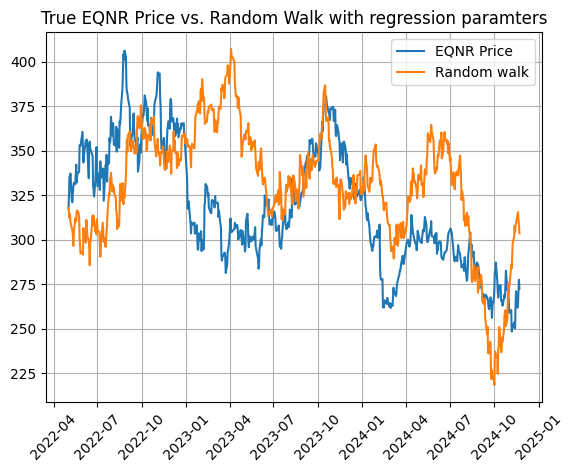

In [26]:
plt.plot(df_eqnr['Date'], df_eqnr['Close_eqnr'], label="EQNR Price")
plt.plot(df_eqnr['Date'], df_eqnr['Random_walk'], label="Random walk")

plt.xticks(rotation=45)
plt.title("True EQNR Price vs. Random Walk with regression paramters")
plt.legend()
plt.grid()
plt.show()

### Ch 2. Testing weather a change in lagged oil price has significant effect on todays drift and time-trend. 

Firstly testing weather change in lagged oil price can be explained by time.

````r
pdiff_oil_lag = 100*(oil_lag[-1] - lag(oil_lag)[-length(oil_lag)+1]) / lag(oil_lag)[-length(oil_lag)+1]
time_lag = time[-1]
regr2 = lm(time_lag ~ pdiff_oil_lag)
summary(regr2)
````

With the results:
````r
Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   326.9403     7.4565  43.846   <2e-16 ***
pdiff_oil_lag   0.7527     3.3103   0.227     0.82    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 187 on 627 degrees of freedom
Multiple R-squared:  8.245e-05,	Adjusted R-squared:  -0.001512 
F-statistic: 0.0517 on 1 and 627 DF,  p-value: 0.8202
````

No statistical evidence of a downward or upwards trend in daily change in oil price can be explained by time. 

Testing weather change in lagged oil price can explain todays drift. 

````r
close_lag2 = close_lag[-length(close_lag)+1]
close_true2 = close_true[-length(close_true)+1]
regr4 = lm(close_true2 ~ time_lag + close_lag2 + pdiff_oil_lag)
summary(regr4)
````

With the results:
````r
Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   10.728174   3.595020   2.984  0.00295 ** 
time_lag      -0.003079   0.001811  -1.700  0.08962 .  
close_lag2     0.969766   0.009858  98.375  < 2e-16 ***
pdiff_oil_lag -0.233860   0.106828  -2.189  0.02896 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.012 on 625 degrees of freedom
Multiple R-squared:  0.9695,	Adjusted R-squared:  0.9694 
F-statistic:  6622 on 3 and 625 DF,  p-value: < 2.2e-16
`````

A negative significant correlation between yesterdays price difference and todays drift. 

Can use this to simulate a drift that is dependent of yesterdays change in oil price, that is

$P(Drift > \mu | \%\Delta Oil_{t-1} < 0) > P(Drift > \mu | \%\Delta Oil_{t-1} > 0) $

In [31]:
with open('EQNR_summary_no_oil.json') as file:
    coefficients_data = json.load(file)

ser = coefficients_data['ser'][0]
coefficients = coefficients_data['coefficients']

df_eqnr['Date'] = pd.to_datetime(df_eqnr['Date'])
df_oil['Date'] = pd.to_datetime(df_oil['Date'])

y = [0 for i in range(len(df_eqnr))]
y[0] = df_eqnr['Close_eqnr'][0]
y[1] = df_eqnr['Close_eqnr'][0]
y[2] = df_eqnr['Close_eqnr'][0]


for t in range(2, len(df_eqnr)-1):
    y[t+1] = \
    coefficients[0]['Estimate'] + \
    coefficients[1]['Estimate']*t + \
    coefficients[2]['Estimate']*y[t] + np.random.normal(0, ser)
    #coefficients[3]['Estimate']* (100*((df_oil.loc[t-1, 'Close_oil'] - df_oil.loc[t-2, 'Close_oil']) / df_oil.loc[t-2, 'Close_oil'])) + \
    

df_eqnr['Random_walk'] = y

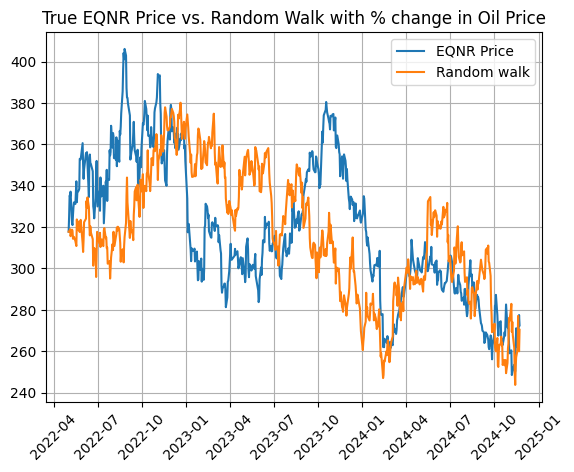

In [32]:
plt.plot(df_eqnr['Date'], df_eqnr['Close_eqnr'], label="EQNR Price")
plt.plot(df_eqnr['Date'], df_eqnr['Random_walk'], label="Random walk")

plt.xticks(rotation=45)
plt.title("True EQNR Price vs. Random Walk with % change in Oil Price")
plt.legend()
plt.grid()
plt.show()

Looks like a slightly better fit

### Ch 3. Testing for Markov Stationarity using the following criteria

$ | \%\Delta Price_t | <= 0.10\% $:  No change

$ \%\Delta Price_t < -0.10\% $:  Negative change

$ \%\Delta Price_t > 0.10\% $:  Positive change

For the Markov Chain, neglecting all probabilities where $ P(A | B) < 10\% $ at the 10% level, this is to ensure we wont get a perfect normal vector. 

In [39]:
def compute_relative_transition_matrix_with_threshold(series, alpha=0.1):
    matrix = np.zeros((3, 3), dtype=int)

    POSITIVE, NO_CHANGE, NEGATIVE = 0, 1, 2
    
    def classify_change(delta):
        if delta > 0.001:  # Positive change: > 0.10%
            return POSITIVE
        elif delta < -0.001:  # Negative change: < -0.10%
            return NEGATIVE
        else:  # No change: abs(delta) < 0.10%
            return NO_CHANGE
    
    last_state = NO_CHANGE

    # Count transitions
    for i in range(1, len(series)):
        prev_value = series[i - 1]
        curr_value = series[i]
        delta = (curr_value - prev_value) / prev_value
        
        current_state = classify_change(delta)
        matrix[last_state, current_state] += 1
        last_state = current_state
    
    # Compute the relative transition matrix
    relative_matrix = matrix.astype(float)
    row_sums = relative_matrix.sum(axis=1, keepdims=True)
    
    # Avoid division by zero for rows with no transitions
    relative_matrix = np.divide(relative_matrix, row_sums, where=(row_sums != 0))
    
    # Apply thresholding
    relative_matrix[relative_matrix < alpha] = 0.0
    
    # Re-normalize the rows to sum to 1
    row_sums_after_threshold = relative_matrix.sum(axis=1, keepdims=True)
    relative_matrix = np.divide(
        relative_matrix, row_sums_after_threshold, where=(row_sums_after_threshold != 0)
    )
    
    return relative_matrix


relative_transition_matrix = compute_relative_transition_matrix_with_threshold(df_eqnr['Close_eqnr'])

print("Relative Transition Matrix:")
print(relative_transition_matrix)


Relative Transition Matrix:
[[0.5122807 0.        0.4877193]
 [0.5625    0.        0.4375   ]
 [0.4911032 0.        0.5088968]]


#### Find Eigenvector for `relative_transition_matrix`, call it $ M $

Observe that negleting events at the 10\% level yield no probability of stasionarity. A random change must occur.


Need to find $ \vec{v} $ such that $ \vec{v}M = \lambda M$, where $ \lambda = 1 $ This is a stasionary Markov state, given by the Eiegenvector $ \vec{v} $ of $ M $ with Eigenvalue $ \lambda = 1 $ 

In [36]:
matrix_minus_identity = relative_transition_matrix - np.eye(relative_transition_matrix.shape[0])
# Compute the null space of (M - I) to find eigenvector for eigenvalue = 1
# Perform Singular Value Decomposition (SVD)
u, s, vh = np.linalg.svd(matrix_minus_identity)

# Null space corresponds to the singular vector with zero singular value
# Find the index of the smallest singular value
tolerance = 1e-10  # Numerical tolerance for detecting zero singular values
null_space = vh[np.isclose(s, 0, atol=tolerance)]

if null_space.size > 0:
    # Take the first null-space vector and normalize it to make its sum = 1
    eigenvector = null_space[0]
    eigenvector = eigenvector / eigenvector.sum()
    print("Eigenvector for eigenvalue = 1:")
    print(eigenvector)
else:
    print("No eigenvector found corresponding to eigenvalue = 1.")


Eigenvector for eigenvalue = 1:
[0.33333333 0.33333333 0.33333333]


We have then that the eigenvalue of 

$ M = \begin{bmatrix} 0.48344371 & 0.05629139 & 0.4602649  \\ 0.54545455 & 0.03030303 & 0.42424242 \\ 0.46779661 & 0.04745763 & 0.48474576 \end{bmatrix}$ is given by

$ \vec{v} = \begin{bmatrix} 1/3 & 1/3 & 1/3 \end{bmatrix} $

Hence, in a stasionary process EQNR moves in a perfect random process. 

### Plan

- Finne negativt korrelerte aksjer og bruke monte carlo simulering til å finne beste allokering av de to for å hedge mot tap.

- Legge til stop-loss og for å se om det hedger enda mer. 

- Se etter avtagende / økende drift, kan indikere at markedet forventer mer eller mindre volatil periode. 